In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
from utils import *
%matplotlib inline

Using TensorFlow backend.


In [25]:
data = pd.read_csv('SLDC_Data/2018/01/01-01-2018.csv')
data['date'] = '01-10-2017'
data = extract_dt(data)
load_data = data['value'].values # (length)
load_data = load_data.reshape(-1, 1) # (length, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
load_data = scaler.fit_transform(load_data)

In [27]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [28]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [29]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))

In [30]:
model.load_weights('models/lstm-v1.h5')

In [31]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 84.70 RMSE
Test Score: 41.16 RMSE


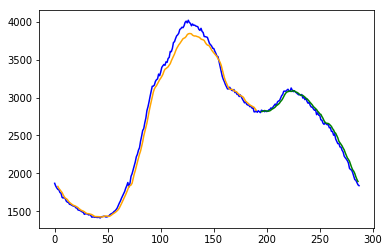

In [32]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(load_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(load_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(load_data)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(load_data), c='blue')
plt.plot(trainPredictPlot, c='orange')
plt.plot(testPredictPlot, c='green')
plt.show()